In [1]:
__author__ = 'Fernandes'
%load_ext autoreload
%autoreload 2
###################### IMPORT LIBRARIES################################ '''

import os
from Miguel_load_exp_Femtonics_python3 import *
import matplotlib.pyplot as plt
import numpy as np
from filepicker_python3 import *
import shelve
import time
import seaborn as sns
import pickle
import sys
from sklearn import linear_model, metrics  
from filepicker_python3 import pickfiles
from ipywidgets import interact
from helper_functions_imaging import *

In [2]:
'''Region of sensor used (GCaMP)'''
GCaMP = 'gcamp6s'


'''Region of the brain imaged'''
regions=['right_tectum'] #can run over multiple regions

In [3]:
''' ###################### Loading The Files ####################### '''
reg_path=('/Users/fernandes/Dropbox (Personal)/Github_Migas/Neuronal_imaging/example_ROIs.p')
print (reg_path)

/Users/fernandes/Dropbox (Personal)/Github_Migas/Neuronal_imaging/example_ROIs.p


In [4]:
for region in regions:

    '''Load files'''
    print (region)
    print ('Loading...')
    tload1 = time.time()
    Exp_MF = load_experiment_w_pickle_new_femtonics_2019(reg_path, corrected=False)
    tload2 = time.time()
    tload = tload2 - tload1
    print ('Done - Time for Image Loading:', tload)
    print ('Image - Dimensions:', np.shape(Exp_MF.images))
    try:
        filename = Exp_MF.metadata['Experiment code']+'_'+Exp_MF.metadata['Fish name']+'_'+Exp_MF.metadata['Recording name']+'_'+Exp_MF.metadata['Visual Stim']
    except:
        filename = Exp_MF.metadata['Experiment code']+'_'+Exp_MF.metadata['Fish name']+'_'+Exp_MF.metadata['Recording name']+'_'+Exp_MF.metadata['Visual Stimulation']
    filename_dir = os.path.dirname(reg_path) +'/'+ filename

    '''Take shelve file with extracted ROIs'''
    curr_path=str(os.path.dirname(reg_path))
    os.chdir(curr_path)
    file_shelve = os.path.dirname(reg_path) + '/' + Exp_MF.metadata['Recording name'].replace("M", "F")+'_UGf_ROIs'+'_'+ str(region)+'.shv'
    shelvename = file_shelve

    analysed_shv = shelve.open(os.path.basename(os.path.normpath(file_shelve)), protocol=2)

    ROI_settings = analysed_shv['settings'] #if shelve cannot be read pass everything and move on to next file

    metadata = Exp_MF.metadata #take metadata
    protocol = Exp_MF.stimuli

    frame_rate = float(1 / Exp_MF.dt)

    '''which GCaMP used?'''
    if GCaMP == 'gcamp6s':
        print ('GCamP6s used')
        exp_decay_kernel = Exp_MF.exp_decay_kernel_g6s()
    if GCaMP == 'gcamp6f':
        exp_decay_kernel = Exp_MF.exp_decay_kernel_g6f()


    ''' ###################### Building Regressors ##################################################################### '''      

    stim1_main=np.where(Exp_MF.stimuli['stim1_presence']>0)
    stim2_main=np.where(Exp_MF.stimuli['stim2_presence']>0)
    stim3_main=np.where(Exp_MF.stimuli['stim3_presence']>0)

    t=Exp_MF.stimuli['t'] #t is time from protocol file

    reg_stim1=make_reg(regressor_to_make=stim1_main, steps=Exp_MF.steps,t=t,frame_rate=frame_rate)
    reg_stim2=make_reg(regressor_to_make=stim2_main, steps=Exp_MF.steps,t=t,frame_rate=frame_rate)
    reg_stim3=make_reg(regressor_to_make=stim3_main, steps=Exp_MF.steps,t=t,frame_rate=frame_rate)

    reg_stim1_high = find_timepoints_reg_high(reg_stim1)
    reg_stim2_high = find_timepoints_reg_high(reg_stim2)
    reg_stim3_high = find_timepoints_reg_high(reg_stim3)
    reg_all_high=np.concatenate((reg_stim1_high[0],reg_stim2_high[0],reg_stim3_high[0]))


    '''Convolve regressors'''

    reg_stim1_conv = (Exp_MF.convolve_regressors(reg_stim1,exp_decay_kernel))
    reg_stim2_conv = (Exp_MF.convolve_regressors(reg_stim2,exp_decay_kernel))
    reg_stim3_conv = (Exp_MF.convolve_regressors(reg_stim3,exp_decay_kernel))


    reg_stim1_high = find_timepoints_reg_high(reg_stim1)
    reg_stim2_high = find_timepoints_reg_high(reg_stim2)
    reg_stim3_high = find_timepoints_reg_high(reg_stim3)


    '''remove ROIs based on regression that are not locked to any stim (regressors)'''
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    reg = linear_model.LinearRegression() 


    analysed_shv['ROI_traces_deltaF_F0']=dFoverF_ROIs(analysed_shv['ROI_traces'])
    ROIs_seed_deltaF_F0=analysed_shv['ROI_traces_deltaF_F0']
    regs_conv = np.asarray([reg_stim1_conv,reg_stim2_conv,reg_stim3_conv])
    regs_timepoints =  [reg_stim1_high,reg_stim2_high,reg_stim3_high] #timepoints for regressors
  
    r2_threshold=0.05#'''regression threshold for ROIs''' 
    '''fit for all regressors and then take the r2, remove all ROIs that are not highly correlated'''
    idx,r2,coefs = filter_rois(regs_conv, ROIs_seed_deltaF_F0, r2_threshold,reg) #filter spontaneous away ROIs
    '''ROIs_seed_deltaF_F0[idx , :] #filtered ROIs''' 
    activity_ROIs_filt=mean_for_timepoints_with_ROIs(ROIs_seed_deltaF_F0[idx , :], regs=regs_timepoints, how_long=5) #how many frames

    '''#if ROIs pass threshold'''

    if r2.max()>r2_threshold: #only if ROIS pass threshold of r2
        df_save=pd.DataFrame(activity_ROIs_filt)

        keys_stim = ['prey', 'looming', 'dimming']
        df_save.columns=keys_stim
        df_metadata=pd.Series(metadata)


        '''filter neurons by class [idx,:]'''
        coef_stim1_filt=coefs[idx,:][:,0] #for prey
        coef_stim2_filt=coefs[idx,:][:,1] #for loomming
        coef_stim3_filt=coefs[idx,:][:,2] #for dimming

        max_correlation_values_found=max_correlation_values(coef_stim1_filt,coef_stim2_filt,coef_stim3_filt) #find maximum value for each regressor

        prey_rois=np.where(coef_stim1_filt==max_correlation_values_found)
        looming_rois=np.where(coef_stim2_filt==max_correlation_values_found)
        dimming_rois=np.where(coef_stim3_filt==max_correlation_values_found)

        prey_rois_to_save=ROIs_seed_deltaF_F0[idx][prey_rois]
        looming_rois_to_save=ROIs_seed_deltaF_F0[idx][looming_rois]
        dimming_rois_to_save=ROIs_seed_deltaF_F0[idx][dimming_rois]

        analysed_shv.close() #close shelve file


print ('DONE ALL FILES')



right_tectum
Loading...
Done - Time for Image Loading: 5.382801055908203
Image - Dimensions: (439, 345, 559)
GCamP6s used
DONE ALL FILES


# Metadata from experiment

In [5]:
metadata

{'Experiment code': 'MF343',
 'Recording name': 'M4',
 'Visual Stimulation': 'Prey vs Looming vs Dimming',
 'Fish name': 'gad1bgalUAS NTRmch HucnlsG6s left eye PRE',
 'Date_Time': 'd_20200117_ t_113240',
 'Imaging time': '420 sec',
 'Imaging rate': '1Hz 1 plane',
 'Notes_': 'monocular'}

In [6]:
ROIs_seed_deltaF_F0

array([[1.30372351, 1.33589399, 1.35685345, ..., 0.22421512, 0.23576057,
        0.25036587],
       [0.68697448, 0.66299846, 0.73401614, ..., 0.12826612, 0.13901776,
        0.12742805],
       [0.6562971 , 0.59936269, 0.60723362, ..., 0.03472879, 0.03139012,
        0.02547576],
       ...,
       [0.27760876, 0.23184323, 0.22601176, ..., 0.08066913, 0.06958619,
        0.04749682],
       [0.11212086, 0.10181155, 0.11130001, ..., 0.04471489, 0.04416309,
        0.02516504],
       [0.06415005, 0.06092715, 0.06942013, ..., 0.04961192, 0.05060839,
        0.06207445]])

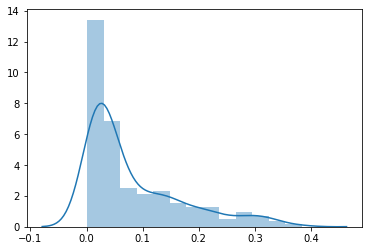

In [7]:
'''Array of r2 scores'''
sns.distplot(r2)

# Clustering all neurons
White lines: stimulus presentation

/Users/fernandes/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


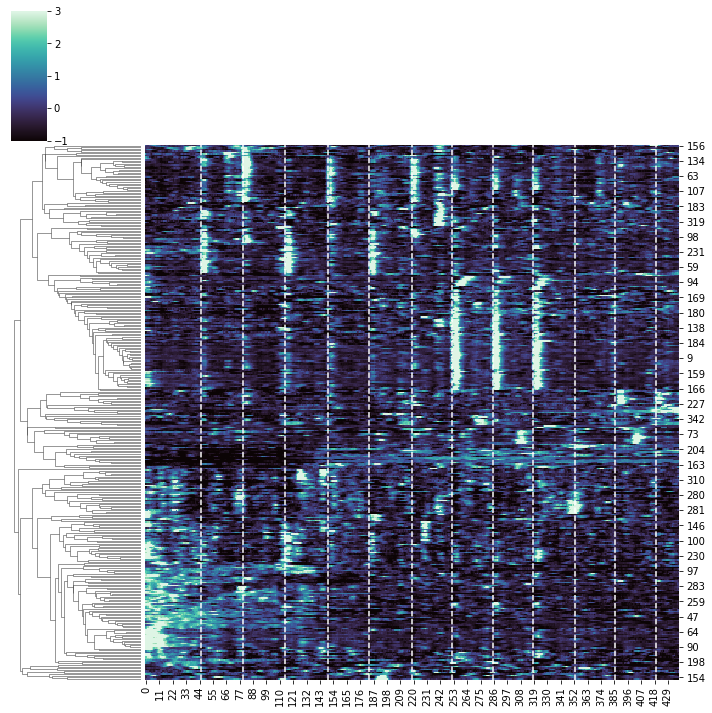

In [8]:
result=sns.clustermap(ROIs_seed_deltaF_F0[:], metric="correlation", cmap="mako",col_cluster=False,\
   robust=True, figsize=(10,10), z_score=0,vmin=-1, vmax=3);
xposition = reg_all_high
ax = result.ax_heatmap
for xc in xposition:
    ax.axvline(x=xc, color='w', linestyle='--')

In [9]:
'''Save all Neurons'''
all_rois_df=pd.DataFrame(ROIs_seed_deltaF_F0)
all_rois_df.to_csv('all_rois_df.csv')

# Clustering selected neurons. 
Removed neurons that are not locked to stimuli. 
White lines: stimulus presentation

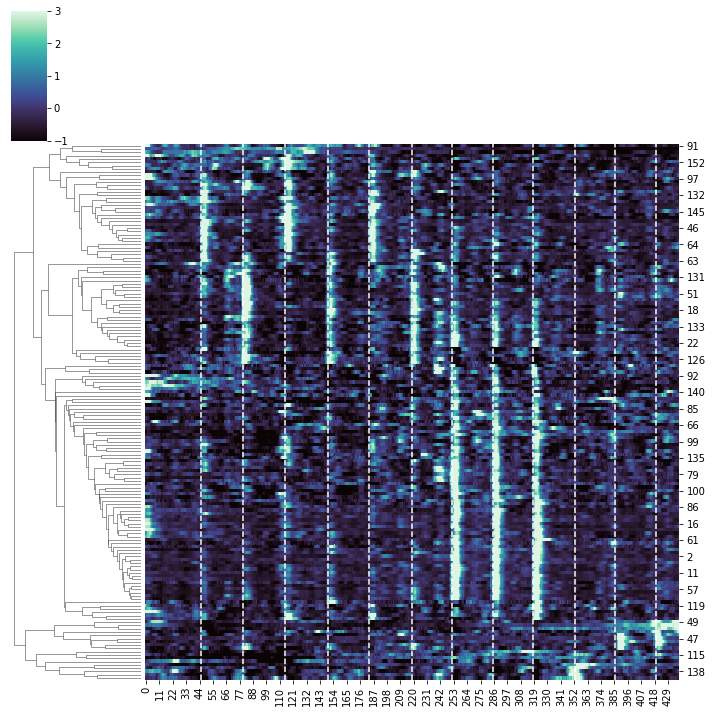

In [10]:
result=sns.clustermap(ROIs_seed_deltaF_F0[idx], metric="correlation", cmap="mako",col_cluster=False,\
   robust=True, figsize=(10,10), z_score=0,vmin=-1, vmax=3);    
ax = result.ax_heatmap
for xc in xposition:
    ax.axvline(x=xc, color='w', linestyle='--')

In [11]:
'''Save selected Neurons'''
rois_r2_pass=pd.DataFrame(ROIs_seed_deltaF_F0[idx])
rois_r2_pass
rois_r2_pass.to_csv('rois_r2_pass.csv')

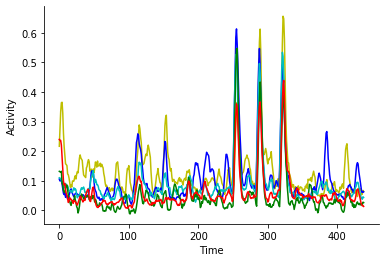

In [33]:
'''Plot some example neurons'''
color_roi=['y','b','c','g','r']
for c, neuron in enumerate(ROIs_seed_deltaF_F0[idx][5:10]):
    plt.plot(neuron, color=color_roi[c])
    plt.xlabel('Time')
    plt.ylabel('Activity')
    sns.despine()

# Check all selected neurons

In [12]:
@interact
def showTraces(roi:(0,ROIs_seed_deltaF_F0[idx].shape[0])):
    fig,ax =plt.subplots(figsize=(10,5))
    plt.plot(ROIs_seed_deltaF_F0[roi], color='k')
    p0=plt.plot(reg_stim1_conv, lw=1, color='orange' )
    p1=plt.plot(reg_stim2_conv, lw=1, color='fuchsia')
    p2=plt.plot(reg_stim3_conv, lw=1, color='turquoise')
    ax.legend((p0[0], p1[0],p2[0]), ('Prey', 'Looming', 'Dimming'), bbox_to_anchor=(1,1))
    sns.despine()

interactive(children=(IntSlider(value=81, description='roi', max=163), Output()), _dom_classes=('widget-intera…

# Check Prey-responsive neurons

In [13]:
@interact
def showTraces(roi:(0,prey_rois_to_save.shape[0]-1)):
    fig,ax =plt.subplots(figsize=(10,5))
    p0=plt.plot(reg_stim1_conv, lw=1, color='orange' )
    p1=plt.plot(reg_stim2_conv, lw=1, color='fuchsia')
    p2=plt.plot(reg_stim3_conv, lw=1, color='turquoise')
    ax.legend((p0[0], p1[0],p2[0]), ('Prey', 'Looming', 'Dimming'), bbox_to_anchor=(1,1))
    sns.despine()
    plt.plot(prey_rois_to_save[roi], color='k')

interactive(children=(IntSlider(value=27, description='roi', max=54), Output()), _dom_classes=('widget-interac…

# Check Looming-responsive neurons

In [14]:
from ipywidgets import interact
@interact
def showTraces(roi:(0,looming_rois_to_save.shape[0]-1)):
    fig,ax =plt.subplots(figsize=(10,5))
    p0=plt.plot(reg_stim1_conv, lw=1, color='orange' )
    p1=plt.plot(reg_stim2_conv, lw=1, color='fuchsia')
    p2=plt.plot(reg_stim3_conv, lw=1, color='turquoise')
    ax.legend((p0[0], p1[0],p2[0]), ('Prey', 'Looming', 'Dimming'), bbox_to_anchor=(1,1))
    sns.despine()
    plt.plot(looming_rois_to_save[roi], color='k')

interactive(children=(IntSlider(value=45, description='roi', max=91), Output()), _dom_classes=('widget-interac…

# Check Dimming-responsive neurons

In [15]:
from ipywidgets import interact
@interact
def showTraces(roi:(0,dimming_rois_to_save.shape[0]-1)):
    fig,ax =plt.subplots(figsize=(10,5))
    p0=plt.plot(reg_stim1_conv, lw=1, color='orange' )
    p1=plt.plot(reg_stim2_conv, lw=1, color='fuchsia')
    p2=plt.plot(reg_stim3_conv, lw=1, color='turquoise')
    ax.legend((p0[0], p1[0],p2[0]), ('Prey', 'Looming', 'Dimming'), bbox_to_anchor=(1,1))
    sns.despine()
    plt.plot(dimming_rois_to_save[roi], color='k')

interactive(children=(IntSlider(value=7, description='roi', max=15), Output()), _dom_classes=('widget-interact…